<a href="https://colab.research.google.com/github/baykaa/Bio_ClinicalBERT-fine-tuned/blob/main/Toxicity_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Toxicity Detection in Online Comments Using Pre-trained Transformers

# 01. Model & Dataset

In [1]:
!pip install transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


**Import Libraries**

In [2]:
# Import libraries
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from datasets import load_dataset
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
import seaborn as sns
import matplotlib.pyplot as plt


**Preprocessing Setup**

**Preprocessing process with:**

*   Lowercase
*   Remove special characters and numbers
*   Tokenize text
*   Remove stopwords
*   Stemming
*   Lemmatization

In [9]:
# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')

# Initialize stopwords, stemmer, and lemmatizer
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# Define preprocessing function
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^a-z\s]', '', text)  # Remove special characters and numbers
    tokens = word_tokenize(text)  # Tokenize text
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    tokens = [ps.stem(word) for word in tokens]  # Apply stemming
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Apply lemmatization
    return ' '.join(tokens)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


**Load the Dataset**

In [10]:
# Load the Civil Comments dataset
dataset = load_dataset('google/civil_comments')
train_df = pd.DataFrame(dataset['train'][:100000])
test_df = pd.DataFrame(dataset['test'][:10000])

print(train_df['text'].value_counts())

text
Sᴛᴀʀᴛ ᴡᴏʀᴋɪɴɢ ғʀᴏᴍ ʜᴏᴍᴇ! Gʀᴇᴀᴛ ᴊᴏʙ ғᴏʀ sᴛᴜᴅᴇɴᴛs, sᴛᴀʏ-ᴀᴛ-ʜᴏᴍᴇ ᴍᴏᴍs ᴏʀ ᴀɴʏᴏɴᴇ ɴᴇᴇᴅɪɴɢ ᴀɴ ᴇxᴛʀᴀ ɪɴᴄᴏᴍᴇ... Yᴏᴜ ᴏɴʟʏ ɴᴇᴇᴅ ᴀ ᴄᴏᴍᴘᴜᴛᴇʀ ᴀɴᴅ ᴀ ʀᴇʟɪᴀʙʟᴇ ɪɴᴛᴇʀɴᴇᴛ ᴄᴏɴɴᴇᴄᴛɪᴏɴ... Mᴀᴋᴇ $90 ʜᴏᴜʀʟʏ ᴀɴᴅ ᴜᴘ ᴛᴏ $12000 ᴀ ᴍᴏɴᴛʜ ʙʏ ғᴏʟʟᴏᴡɪɴɢ ʟɪɴᴋ ᴀᴛ ᴛʜᴇ ʙᴏᴛᴛᴏᴍ ᴀɴᴅ sɪɢɴɪɴɢ ᴜᴘ... Yᴏᴜ ᴄᴀɴ ʜᴀᴠᴇ ʏᴏᴜʀ ғɪʀsᴛ ᴄʜᴇᴄᴋ ʙʏ ᴛʜᴇ ᴇɴᴅ ᴏғ ᴛʜɪs ᴡᴇᴇᴋ... \n\n+++++++++http://www.cashapp24.com/                                                                                                                                                                                                                                                                                                                                                                   117
Start working at home with Google! It's by-far the best job I've had. Last Wednesday I got a brand new BMW since getting a check for $6474 this - 4 weeks past. I began this 8-months ago and immediately was bringing home at least $77 per hour. I work through this link, go to tech tab

In [12]:
# Preprocess the training dataset
train_df = train_df[train_df['toxicity'] > 0]  # Remove rows with zero toxicity
train_df['cleaned_text'] = train_df['text'].apply(preprocess_text)
train_df.head(10)

,text,toxicity,severe_toxicity,obscene,threat,insult,identity_attack,sexual_explicit,cleaned_text
4,haha you guys are a bunch of losers.,0.893617,0.021277,0.000000,0.000000,0.872340,0.021277,0.000000,haha guy bunch loser
5,ur a sh*tty comment.,0.666667,0.047619,0.638095,0.000000,0.333333,0.000000,0.009524,ur shtti comment
6,hahahahahahahahhha suck it.,0.457627,0.050847,0.305085,0.000000,0.254237,0.000000,0.220339,hahahahahahahahhha suck
11,This is a great story. Man. I wonder if the pe...,0.440000,0.000000,0.293333,0.000000,0.320000,0.000000,0.040000,great stori man wonder person yell shut fuck e...
13,It's ridiculous that these guys are being call...,0.600000,0.000000,0.100000,0.100000,0.600000,0.000000,0.000000,ridicul guy call protest arm threat violenc ma...
14,This story gets more ridiculous by the hour! A...,0.500000,0.000000,0.000000,0.000000,0.300000,0.000000,0.000000,stori get ridicul hour love peopl send guy dil...
19,"Angry trolls, misogynists and Racists"", oh my....",0.500000,0.000000,0.000000,0.000000,0.500000,0.100000,0.000000,angri troll misogynist racist oh doesnt take i...
31,Yet call out all Muslims for the acts of a few...,0.912500,0.050000,0.237500,0.112500,0.887500,0.612500,0.000000,yet call muslim act get pillori okay smear ent...
34,This bitch is nuts. Who would read a book by a...,0.830769,0.107692,0.661538,0.000000,0.830769,0.338462,0.061538,bitch nut would read book woman
39,Pity the menu lost so much vegan food! The Mas...,0.166667,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,piti menu lost much vegan food mash tun favori...


In [16]:
num_rows = len(train_df)
print(f"Number of rows after processing from 100,000: {num_rows}")

Number of rows: 26610


In [17]:
# Preprocess the test dataset
test_df = test_df[test_df['toxicity'] > 0]  # Remove rows with zero toxicity
test_df['cleaned_text'] = test_df['text'].apply(preprocess_text)
test_df.head(10)

,text,toxicity,severe_toxicity,obscene,threat,insult,identity_attack,sexual_explicit,cleaned_text
1,This is malfeasance by the Administrator and t...,0.100000,0.000000,0.000000,0.0,0.100000,0.0,0.0,malfeas administr board wast money
2,@Rmiller101 - Spoken like a true elitist. But ...,0.300000,0.000000,0.000000,0.0,0.200000,0.0,0.0,rmiller spoken like true elitist look bud reaw...
6,Our oils read; President IS taking different ...,0.851852,0.018519,0.203704,0.0,0.796296,0.0,0.0,oil read presid take differ tactic deal corrup...
7,'Work together'? Dream on. The liberals are al...,0.500000,0.100000,0.000000,0.1,0.400000,0.1,0.0,work togeth dream liber alreadi busi creat nex...
11,Between racist Eastman and 'Slappy' Wilson the...,0.500000,0.000000,0.000000,0.0,0.500000,0.0,0.0,racist eastman slappi wilson wasilla deleg emb...
19,Well here we go again. Let's continue to subs...,0.500000,0.000000,0.000000,0.0,0.500000,0.0,0.0,well go let continu subsid cost power cost con...
21,It's a black mark on the previous administrati...,0.200000,0.000000,0.000000,0.0,0.100000,0.2,0.0,black mark previou administr allow massiv ille...
22,In the last decades the rich have god signific...,0.200000,0.000000,0.000000,0.0,0.200000,0.0,0.0,last decad rich god signific richer poor poore...
26,"Ignorance is bliss, ain't it?",0.200000,0.000000,0.000000,0.0,0.200000,0.0,0.0,ignor bliss aint
28,Lets make some fact based statements. Half of ...,0.100000,0.000000,0.000000,0.0,0.100000,0.0,0.0,let make fact base statement half fake news


In [19]:
num_rows = len(test_df)
print(f"Number of rows after processing from 10,000: {num_rows}")

Number of rows after processing from 10,000: 2989


# 03. Training the Model

In [20]:
# Load the pre-trained toxicity model and tokenizer
model_name = "unitary/toxic-bert"
toxicity_pipeline = pipeline("text-classification", model=model_name)

# Performing toxicity detection on the test dataset
test_df['predicted_toxicity'] = test_df['cleaned_text'].apply(lambda x: toxicity_pipeline(x)[0]['label'])
test_df['confidence_score'] = test_df['cleaned_text'].apply(lambda x: toxicity_pipeline(x)[0]['score'])



---



# 04. Evaluate the Model

Map True and Predicted Labels

In [21]:
# Map true and predicted labels
test_df['true_label'] = ['Toxic' if label > 0.5 else 'Non-toxic' for label in test_df['toxicity']]
test_df['predicted_label'] = ['Toxic' if label == 'LABEL_1' else 'Non-toxic' for label in test_df['predicted_toxicity']]

In [22]:
# Calculate accuracy
accuracy = accuracy_score(test_df['true_label'], test_df['predicted_label'])
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 80.50%


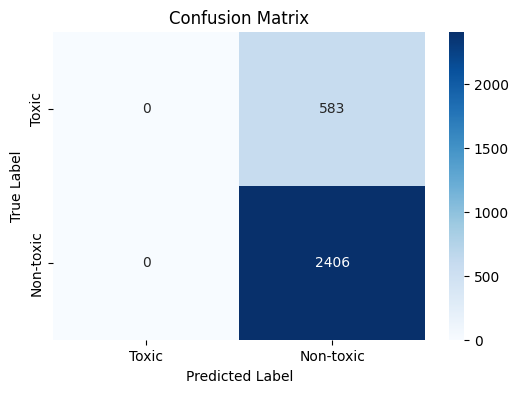

In [23]:
# Generate confusion matrix
conf_matrix = confusion_matrix(test_df['true_label'], test_df['predicted_label'], labels=['Toxic', 'Non-toxic'])

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Toxic', 'Non-toxic'], yticklabels=['Toxic', 'Non-toxic'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# 05. Conclusion



*   True Negatives (TN) = 2406: The model correctly identified 2406 non-toxic samples as non-toxic.
*   False Positives (FP) = 0: The model did not incorrectly classify any non-toxic samples as toxic.
*   False Negatives (FN) = 583: The model failed to identify 583 toxic samples and incorrectly classified them as non-toxic.
*   True Positives (TP) = 0: The model did not correctly classify any toxic samples as toxic.



Insights on accuracy:

The model achieves a high accuracy because of the large number of correctly classified non-toxic samples (TN = 2406). However, this is misleading since it fails entirely at detecting toxic samples (TP = 0).


Class Imbalance or Model Bias:

The confusion matrix reveals a significant bias towards predicting all samples as non-toxic. This indicates that
*  A severe imbalance in the dataset, with many more non-toxic samples compared to toxic ones.

*   The model’s inability to differentiate between toxic and non-toxic content effectively.
*   Toxicity threshold of more than 0.5 is too high for our dataset. Therefore, lowering it to 0.3 and retraining can improve it.

